In [1]:
import sys
sys.path.append("../")
path = "../"

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfmm

from methods.implicit_perturb_2D import *

In [ ]:
pip install tqdm

In [ ]:
pip install gstools

In [ ]:
pip install scikit-fmm

In [ ]:
pip install statsmodels

### Load initial + truth from image w/ thresholding

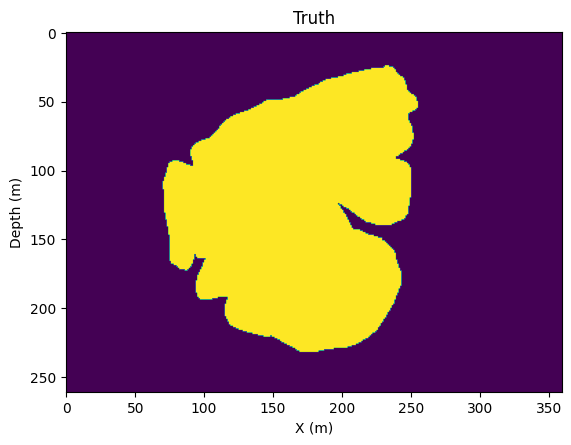

In [2]:
truth = cv2.imread('../data/data_gen_case/imgs/truth1.png', cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(truth, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
truth = thresh

df = pd.DataFrame(truth)
df.to_csv('testing.csv')

plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(thresh)
plt.show()

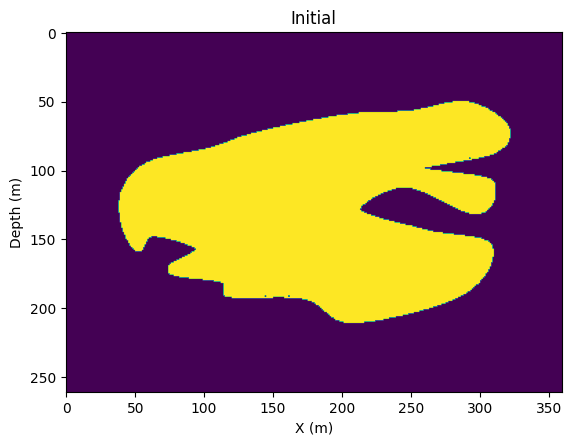

In [3]:
initial = cv2.imread('../data/data_gen_case/imgs/fake1.png', cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(initial, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
truth = thresh

plt.title('Initial')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(thresh)
plt.show()

## testing hand gen shape with a single point

In [ ]:
truth = pd.read_csv('../data/peanut_case/maybe_good_data.csv')
truth = np.array(truth)
DF = pd.DataFrame(truth)

plt.imshow(truth)
plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [ ]:
initial = pd.read_csv('../data/peanut_case/initial_data_maybe_good.csv')
initial = np.array(initial)
DF = pd.DataFrame(initial)

plt.imshow(initial)
plt.title('Initial')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Load new contact points

In [4]:
new_contacts = pd.read_csv("../data/data_gen_case/paths/img1_contacts.csv")

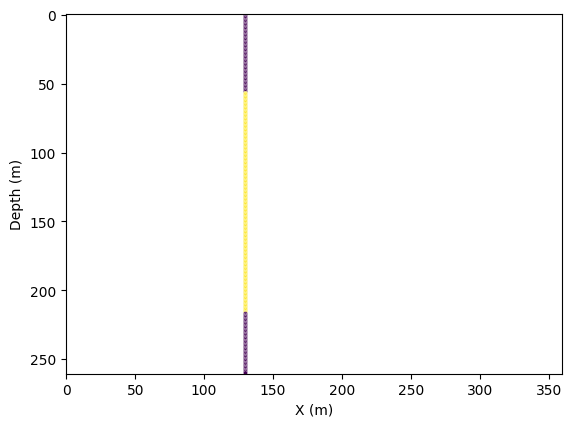

In [5]:
plt.imshow(truth, alpha = 0)
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()


### Initial Model

In [6]:
x_dim, y_dim= truth.shape
print(truth.shape)
x0 = 50; a = 10
y0 = 50; b = 20

x = np.linspace(0, x_dim,x_dim)[:,None]  # x values of interest
y = np.linspace(0, y_dim,y_dim)[:]  # y values of interest, as a "column" array

initial = initial*1

(261, 360)


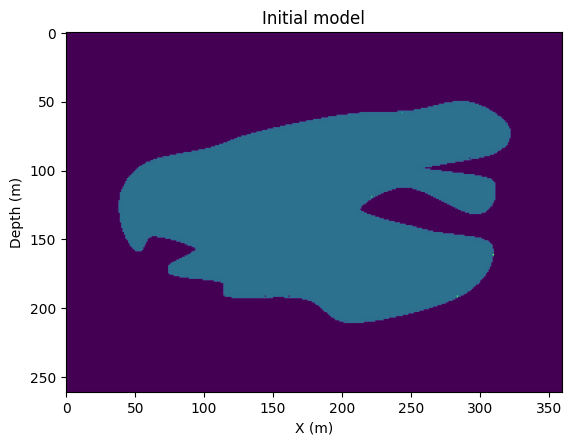

In [7]:
plt.imshow(initial)
plt.title('Initial model')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Trend estimation: MCMC on level sets M(x)

In [8]:
data = np.zeros(initial.shape)
data[:] = np.nan
data[np.array(new_contacts['depth'],dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')] = truth[np.array(new_contacts['depth'], dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')]
data[np.array(new_contacts[new_contacts['contacts']==1]['depth'],dtype = 'int64'),
     np.array(new_contacts[new_contacts['contacts']==1]['x'],dtype = 'int64')] = 0.5

In [9]:
initial = initial - 0.5
model = skfmm.distance(initial)

In [10]:
indicators_x_alpha = data[np.isfinite(data)]
indicators_x_alpha[indicators_x_alpha==0.5]=1

phi_x_alpha_ini = model[np.isfinite(data)]
phi_x_beta_ini = model[data==0.5]

loss_prev, o_ik_prev, o_bias_prev, o_var_prev =  loss_mean_function_v2(indicators_x_alpha,phi_x_alpha_ini,phi_x_beta_ini, model, data)
print(loss_prev)
sigma_coeff = 0.01
print('sigma = ', loss_prev*sigma_coeff)
print(o_ik_prev, o_bias_prev, o_var_prev)

799.6309775250875
sigma =  7.996309775250875
42.31599408298975 371.7133038772668 385.6016795648309


#### run single chain

In [ ]:
iter_num = 3000
[model_cache, loss_cache, para_cache] = McMC_levelsets_2Dv2(model, data, 
                                                loss_function=loss_mean_function_v2,  
                                                sigma = 15, t_step = 1, iter_num = iter_num, 
                                                vel_range_x = [20, 40], vel_range_y = [20, 40],
                                                anisotropy_ang = [0, 180], num_mp = 0)
np.save('loss_cache.npy',loss_cache)
np.save('model_cache.npy',model_cache)
np.save('para_cache.npy',para_cache)

In [12]:
loss_cache = np.load(path+'notebook/loss_cache.npy')
model_cache = np.load(path+'notebook/model_cache.npy')
para_cache = np.load(path+'notebook/para_cache.npy')

#### run multichain

In [13]:
# You can run multiple chains using this code block
import multiprocessing
iter_num = 3000

sigma = 15

input_list = [[model, data, loss_mean_function_v2, sigma,  1, iter_num, [50,100], [30,60],  [0,180], 13],
              [model, data, loss_mean_function_v2, sigma, 1, iter_num, [70,140], [30,60], [0,180], 14],
              [model, data, loss_mean_function_v2, sigma,  1, iter_num, [90,180], [30,60], [0,180], 15]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 3)
    result = pool.map(mp_non_stationary_implicit_2D,input_list)
    pool.close()

 88%|████████▊ | 2655/3000 [20:15:06<13:43,  2.39s/it]

Num_mp: 14Accept ratio: 0.8356713426853708, Loss function at iter 2600: 25.22590231430964


 87%|████████▋ | 2606/3000 [20:13:23<15:28,  2.36s/it]

Num_mp: 13Accept ratio: 0.8376753507014028, Loss function at iter 2600: 24.035230459212947


 89%|████████▊ | 2661/3000 [20:15:20<13:43,  2.43s/it]

Num_mp: 14Accept ratio: 0.7895791583166333, Loss function at iter 2660: 40.435235008991704


 90%|████████▉ | 2692/3000 [20:15:27<11:57,  2.33s/it]

Num_mp: 13Accept ratio: 0.87374749498998, Loss function at iter 2560: 35.70044763605719


 89%|████████▉ | 2670/3000 [20:15:43<14:12,  2.58s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2620: 19.355206977130486


 87%|████████▋ | 2619/3000 [20:14:05<15:26,  2.43s/it]

Num_mp: 15Accept ratio: 0.8677354709418837, Loss function at iter 2700: 29.79553427757476


 87%|████████▋ | 2621/3000 [20:14:09<14:34,  2.31s/it]

Num_mp: 14Accept ratio: 0.845691382765531, Loss function at iter 2620: 25.878417296024875


 90%|█████████ | 2704/3000 [20:15:56<11:20,  2.30s/it]

Num_mp: 13Accept ratio: 0.845691382765531, Loss function at iter 2620: 27.825836219601946


 88%|████████▊ | 2626/3000 [20:16:08<14:38,  2.35s/it]

Num_mp: 14Accept ratio: 0.7835671342685371, Loss function at iter 2680: 33.04259434372078


 90%|█████████ | 2713/3000 [20:16:16<11:06,  2.32s/it]

Num_mp: 13Accept ratio: 0.8717434869739479, Loss function at iter 2580: 35.34606790022268


 86%|████████▌ | 2587/3000 [20:14:48<16:35,  2.41s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2640: 22.116962130354967


 88%|████████▊ | 2642/3000 [20:14:50<14:00,  2.35s/it]

Num_mp: 15Accept ratio: 0.8717434869739479, Loss function at iter 2720: 23.343267094986317


 91%|█████████ | 2724/3000 [20:16:42<11:05,  2.41s/it]

Num_mp: 14Accept ratio: 0.8436873747494991, Loss function at iter 2640: 28.587899791093193


 90%|████████▉ | 2696/3000 [20:16:45<12:17,  2.42s/it]

Num_mp: 13Accept ratio: 0.8476953907815631, Loss function at iter 2640: 26.811303779435107


 90%|█████████ | 2701/3000 [20:16:57<11:51,  2.38s/it]

Num_mp: 14Accept ratio: 0.7895791583166333, Loss function at iter 2700: 31.203773619445446


 88%|████████▊ | 2655/3000 [20:15:21<13:28,  2.34s/it]

Num_mp: 13Accept ratio: 0.8677354709418837, Loss function at iter 2600: 31.93109584400456


 88%|████████▊ | 2655/3000 [20:17:19<13:31,  2.35s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2660: 17.066114376195117


 90%|█████████ | 2711/3000 [20:17:20<11:33,  2.40s/it]

Num_mp: 15Accept ratio: 0.8677354709418837, Loss function at iter 2740: 28.539336233510138


 87%|████████▋ | 2611/3000 [20:15:45<15:36,  2.41s/it]

Num_mp: 14Accept ratio: 0.8376753507014028, Loss function at iter 2660: 35.444369369896386


 89%|████████▉ | 2667/3000 [20:15:49<13:07,  2.36s/it]

Num_mp: 13Accept ratio: 0.8436873747494991, Loss function at iter 2660: 23.26250511068156


 89%|████████▉ | 2672/3000 [20:16:02<13:21,  2.44s/it]

Num_mp: 14Accept ratio: 0.7855711422845691, Loss function at iter 2720: 35.90967943573937


 91%|█████████ | 2724/3000 [20:17:54<11:25,  2.48s/it]

Num_mp: 13Accept ratio: 0.8717434869739479, Loss function at iter 2620: 36.161886442945885


 91%|█████████ | 2730/3000 [20:18:08<11:04,  2.46s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2680: 25.834569806945108


 88%|████████▊ | 2628/3000 [20:16:29<15:29,  2.50s/it]

Num_mp: 15Accept ratio: 0.8677354709418837, Loss function at iter 2760: 26.835657421362697


 90%|████████▉ | 2685/3000 [20:16:34<12:41,  2.42s/it]

Num_mp: 14Accept ratio: 0.8356713426853708, Loss function at iter 2680: 28.55342108217888


 89%|████████▉ | 2683/3000 [20:16:40<12:24,  2.35s/it]

Num_mp: 13Accept ratio: 0.8436873747494991, Loss function at iter 2680: 25.366252803460227


 90%|████████▉ | 2692/3000 [20:16:51<12:26,  2.42s/it]

Num_mp: 14Accept ratio: 0.7915831663326653, Loss function at iter 2740: 31.933846585427617


 91%|█████████▏| 2744/3000 [20:18:43<10:32,  2.47s/it]

Num_mp: 13Accept ratio: 0.8717434869739479, Loss function at iter 2640: 38.50097163109086


 88%|████████▊ | 2646/3000 [20:17:12<14:14,  2.41s/it]

Num_mp: 15Accept ratio: 0.8496993987975952, Loss function at iter 2700: 22.9168199945896


 92%|█████████▏| 2751/3000 [20:19:00<10:18,  2.49s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2780: 29.62377897003197


 90%|████████▉ | 2698/3000 [20:19:06<12:41,  2.52s/it]

Num_mp: 14Accept ratio: 0.8296593186372745, Loss function at iter 2700: 30.59905169318308


 88%|████████▊ | 2653/3000 [20:17:30<14:41,  2.54s/it]

Num_mp: 13Accept ratio: 0.8476953907815631, Loss function at iter 2700: 32.44190692705464


 93%|█████████▎| 2791/3000 [20:19:25<08:21,  2.40s/it]

Num_mp: 14Accept ratio: 0.7875751503006012, Loss function at iter 2760: 30.69210332687242


 91%|█████████ | 2716/3000 [20:17:48<11:05,  2.34s/it]

Num_mp: 13Accept ratio: 0.8717434869739479, Loss function at iter 2660: 33.41578809021941


 92%|█████████▏| 2769/3000 [20:19:44<09:04,  2.36s/it]

Num_mp: 15Accept ratio: 0.8496993987975952, Loss function at iter 2720: 28.391764890912953


 89%|████████▉ | 2667/3000 [20:18:03<13:10,  2.37s/it]

Num_mp: 15Accept ratio: 0.8577154308617234, Loss function at iter 2800: 31.421084115379156


 91%|█████████ | 2718/3000 [20:19:56<11:50,  2.52s/it]

Num_mp: 14Accept ratio: 0.8376753507014028, Loss function at iter 2720: 30.52827412102048


 94%|█████████▎| 2807/3000 [20:20:03<07:32,  2.35s/it]

Num_mp: 13Accept ratio: 0.8436873747494991, Loss function at iter 2720: 30.18747827852509


 93%|█████████▎| 2781/3000 [20:20:12<08:37,  2.36s/it]

Num_mp: 14Accept ratio: 0.7995991983967936, Loss function at iter 2780: 29.92078407468911


 91%|█████████ | 2731/3000 [20:18:36<10:42,  2.39s/it]

Num_mp: 13Accept ratio: 0.8657314629258517, Loss function at iter 2680: 33.946496350033435


 91%|█████████ | 2735/3000 [20:18:46<10:53,  2.46s/it]

Num_mp: 15Accept ratio: 0.8517034068136272, Loss function at iter 2740: 27.43560474805704


 91%|█████████ | 2737/3000 [20:18:51<10:29,  2.39s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2820: 30.658257776672226


 92%|█████████▏| 2747/3000 [20:19:00<09:50,  2.33s/it]

Num_mp: 14Accept ratio: 0.8396793587174349, Loss function at iter 2740: 29.751988972535063


 92%|█████████▏| 2750/3000 [20:19:06<09:06,  2.19s/it]

Num_mp: 13Accept ratio: 0.8557114228456913, Loss function at iter 2740: 30.518571925613053


 90%|████████▉ | 2697/3000 [20:19:15<12:22,  2.45s/it]

Num_mp: 14Accept ratio: 0.7875751503006012, Loss function at iter 2800: 30.245661871656427


 92%|█████████▏| 2751/3000 [20:19:24<10:05,  2.43s/it]

Num_mp: 13Accept ratio: 0.8597194388777555, Loss function at iter 2700: 36.275170378488


 94%|█████████▎| 2808/3000 [20:21:16<07:26,  2.33s/it]

Num_mp: 15Accept ratio: 0.8537074148296593, Loss function at iter 2760: 21.92572088403767


 92%|█████████▏| 2763/3000 [20:19:38<10:12,  2.59s/it]

Num_mp: 15Accept ratio: 0.8637274549098196, Loss function at iter 2840: 26.466201814998374


 92%|█████████▏| 2761/3000 [20:19:48<09:22,  2.36s/it]

Num_mp: 14Accept ratio: 0.8376753507014028, Loss function at iter 2760: 31.178305547430433


 90%|█████████ | 2714/3000 [20:19:55<11:07,  2.33s/it]

Num_mp: 13Accept ratio: 0.8537074148296593, Loss function at iter 2760: 31.063015108535325


 92%|█████████▏| 2765/3000 [20:21:48<08:58,  2.29s/it]

Num_mp: 14Accept ratio: 0.7895791583166333, Loss function at iter 2820: 31.549901431707646


 92%|█████████▏| 2771/3000 [20:20:11<08:43,  2.29s/it]

Num_mp: 13Accept ratio: 0.8597194388777555, Loss function at iter 2720: 31.05413956443027


 92%|█████████▎| 2775/3000 [20:20:19<08:10,  2.18s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2780: 27.733216369974215


 92%|█████████▏| 2773/3000 [20:22:07<08:42,  2.30s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2860: 32.82634041254237


 96%|█████████▌| 2865/3000 [20:22:16<05:16,  2.34s/it]

Num_mp: 14Accept ratio: 0.8356713426853708, Loss function at iter 2780: 31.29235364817678


 96%|█████████▌| 2869/3000 [20:22:25<05:05,  2.34s/it]

Num_mp: 13Accept ratio: 0.8416833667334669, Loss function at iter 2780: 41.04095014806241


 93%|█████████▎| 2794/3000 [20:20:50<08:00,  2.33s/it]

Num_mp: 14Accept ratio: 0.7875751503006012, Loss function at iter 2840: 27.35322118472806


 96%|█████████▌| 2876/3000 [20:22:43<05:05,  2.46s/it]

Num_mp: 13Accept ratio: 0.8557114228456913, Loss function at iter 2740: 32.00924668149122


 93%|█████████▎| 2791/3000 [20:22:51<08:42,  2.50s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2800: 18.299159747846936


 93%|█████████▎| 2797/3000 [20:21:11<08:00,  2.37s/it]

Num_mp: 15Accept ratio: 0.8577154308617234, Loss function at iter 2880: 29.281877500088413


 93%|█████████▎| 2801/3000 [20:21:21<07:50,  2.36s/it]

Num_mp: 14Accept ratio: 0.8356713426853708, Loss function at iter 2800: 29.99573758590634


 95%|█████████▌| 2857/3000 [20:23:14<05:32,  2.33s/it]

Num_mp: 13Accept ratio: 0.8396793587174349, Loss function at iter 2800: 28.76741850900636


 95%|█████████▌| 2861/3000 [20:23:23<05:33,  2.40s/it]

Num_mp: 14Accept ratio: 0.7835671342685371, Loss function at iter 2860: 27.73246054587977


 94%|█████████▍| 2818/3000 [20:21:47<06:55,  2.28s/it]

Num_mp: 13Accept ratio: 0.8517034068136272, Loss function at iter 2760: 31.268885141859457


 92%|█████████▏| 2764/3000 [20:21:54<08:51,  2.25s/it]

Num_mp: 15Accept ratio: 0.8577154308617234, Loss function at iter 2820: 16.822847211759825


 97%|█████████▋| 2901/3000 [20:23:42<03:49,  2.32s/it]

Num_mp: 15Accept ratio: 0.8577154308617234, Loss function at iter 2900: 32.209716485003575


 96%|█████████▌| 2873/3000 [20:23:52<05:09,  2.43s/it]

Num_mp: 14Accept ratio: 0.8336673346693386, Loss function at iter 2820: 32.409431899110494


 94%|█████████▍| 2821/3000 [20:24:03<07:14,  2.42s/it]

Num_mp: 13Accept ratio: 0.8376753507014028, Loss function at iter 2820: 27.84558844970254


 93%|█████████▎| 2778/3000 [20:22:27<08:48,  2.38s/it]

Num_mp: 14Accept ratio: 0.7875751503006012, Loss function at iter 2880: 28.65458798826078


 94%|█████████▍| 2831/3000 [20:22:34<06:41,  2.38s/it]

Num_mp: 13Accept ratio: 0.845691382765531, Loss function at iter 2780: 33.57524975242732


 94%|█████████▍| 2834/3000 [20:22:40<06:17,  2.27s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2840: 18.512510833331138


 94%|█████████▍| 2832/3000 [20:24:29<06:26,  2.30s/it]

Num_mp: 15Accept ratio: 0.8637274549098196, Loss function at iter 2920: 30.88569874948402


 95%|█████████▍| 2837/3000 [20:24:40<06:09,  2.26s/it]

Num_mp: 14Accept ratio: 0.8236472945891784, Loss function at iter 2840: 36.19109769021066


 95%|█████████▌| 2852/3000 [20:23:06<06:20,  2.57s/it]

Num_mp: 13Accept ratio: 0.8396793587174349, Loss function at iter 2840: 23.147586766963656


 95%|█████████▍| 2844/3000 [20:24:58<06:34,  2.53s/it]

Num_mp: 14Accept ratio: 0.7915831663326653, Loss function at iter 2900: 27.159374177385104


 93%|█████████▎| 2801/3000 [20:23:23<08:13,  2.48s/it]

Num_mp: 13Accept ratio: 0.8557114228456913, Loss function at iter 2800: 33.4363935171513


 98%|█████████▊| 2939/3000 [20:25:12<02:30,  2.46s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2860: 17.425245521598985


 94%|█████████▎| 2805/3000 [20:23:33<07:51,  2.42s/it]

Num_mp: 15Accept ratio: 0.8577154308617234, Loss function at iter 2940: 34.96073748639543


 98%|█████████▊| 2947/3000 [20:25:31<02:08,  2.42s/it]

Num_mp: 14Accept ratio: 0.8256513026052104, Loss function at iter 2860: 32.37896681764113


 97%|█████████▋| 2918/3000 [20:25:40<03:20,  2.44s/it]

Num_mp: 13Accept ratio: 0.8496993987975952, Loss function at iter 2860: 20.410404803198432


 96%|█████████▌| 2875/3000 [20:24:03<05:06,  2.45s/it]

Num_mp: 14Accept ratio: 0.7975951903807615, Loss function at iter 2920: 28.16259162637935


 96%|█████████▌| 2879/3000 [20:24:12<04:29,  2.23s/it]

Num_mp: 13Accept ratio: 0.8496993987975952, Loss function at iter 2820: 45.41040253139365


 99%|█████████▊| 2959/3000 [20:26:00<01:40,  2.46s/it]

Num_mp: 15Accept ratio: 0.8637274549098196, Loss function at iter 2880: 18.96819723311293


 99%|█████████▊| 2961/3000 [20:26:06<01:41,  2.61s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2960: 30.341140840763927


 96%|█████████▌| 2876/3000 [20:26:18<05:01,  2.43s/it]

Num_mp: 14Accept ratio: 0.8276553106212425, Loss function at iter 2880: 36.13224744871971


 96%|█████████▋| 2893/3000 [20:24:46<04:22,  2.46s/it]

Num_mp: 13Accept ratio: 0.8476953907815631, Loss function at iter 2880: 24.16425890315412


 95%|█████████▍| 2837/3000 [20:24:51<06:30,  2.40s/it]

Num_mp: 14Accept ratio: 0.7935871743486974, Loss function at iter 2940: 26.61824210299916


 96%|█████████▌| 2887/3000 [20:26:45<04:30,  2.39s/it]

Num_mp: 13Accept ratio: 0.8396793587174349, Loss function at iter 2840: 41.96923690795657


 99%|█████████▉| 2979/3000 [20:26:48<00:50,  2.41s/it]

Num_mp: 15Accept ratio: 0.8637274549098196, Loss function at iter 2900: 23.343068784064123


 99%|█████████▉| 2981/3000 [20:26:53<00:44,  2.37s/it]

Num_mp: 15Accept ratio: 0.8597194388777555, Loss function at iter 2980: 33.530347771845136


 97%|█████████▋| 2901/3000 [20:25:23<03:48,  2.31s/it]

Num_mp: 14Accept ratio: 0.8316633266533067, Loss function at iter 2900: 31.81460278174498


 95%|█████████▌| 2855/3000 [20:25:35<05:48,  2.40s/it]

Num_mp: 13Accept ratio: 0.8476953907815631, Loss function at iter 2900: 25.863335350131237


 97%|█████████▋| 2902/3000 [20:27:22<03:57,  2.43s/it]

Num_mp: 14Accept ratio: 0.7955911823647295, Loss function at iter 2960: 31.887343775468153


100%|█████████▉| 2998/3000 [20:27:32<00:04,  2.32s/it]

Num_mp: 13Accept ratio: 0.8416833667334669, Loss function at iter 2860: 36.50679025210639


 99%|█████████▉| 2966/3000 [20:27:33<01:17,  2.27s/it]

Num_mp: 15Accept ratio: 0.8617234468937875, Loss function at iter 2920: 20.522845618796737


 96%|█████████▌| 2870/3000 [20:26:09<04:43,  2.18s/it]

Num_mp: 14Accept ratio: 0.8276553106212425, Loss function at iter 2920: 31.04298736821247


 96%|█████████▌| 2875/3000 [20:26:19<04:18,  2.07s/it]

Num_mp: 13Accept ratio: 0.845691382765531, Loss function at iter 2920: 23.350801279395235


 96%|█████████▌| 2876/3000 [20:26:21<04:15,  2.06s/it]

Num_mp: 14Accept ratio: 0.7995991983967936, Loss function at iter 2980: 33.455407523105656


100%|█████████▉| 2986/3000 [20:28:15<00:29,  2.08s/it]

Num_mp: 13Accept ratio: 0.8356713426853708, Loss function at iter 2880: 41.46777187427983


 98%|█████████▊| 2932/3000 [20:26:33<02:20,  2.07s/it]

Num_mp: 15Accept ratio: 0.8637274549098196, Loss function at iter 2940: 29.0411525362059


100%|█████████▉| 2995/3000 [20:28:35<00:10,  2.16s/it]

Num_mp: 14Accept ratio: 0.8256513026052104, Loss function at iter 2940: 35.5980161201164


 96%|█████████▋| 2895/3000 [20:27:02<03:38,  2.08s/it]

Num_mp: 13Accept ratio: 0.8496993987975952, Loss function at iter 2940: 24.581596154870006


 98%|█████████▊| 2946/3000 [20:28:56<01:42,  1.90s/it]

Num_mp: 15Accept ratio: 0.8557114228456913, Loss function at iter 2960: 23.54954034927433


 98%|█████████▊| 2952/3000 [20:27:13<01:34,  1.96s/it]

Num_mp: 13Accept ratio: 0.8276553106212425, Loss function at iter 2900: 43.78222528177188


 99%|█████████▉| 2970/3000 [20:27:29<00:54,  1.82s/it]

Num_mp: 14Accept ratio: 0.8236472945891784, Loss function at iter 2960: 35.72006266691997


 99%|█████████▉| 2976/3000 [20:27:40<00:43,  1.81s/it]

Num_mp: 13Accept ratio: 0.8637274549098196, Loss function at iter 2960: 23.549135571875855


 99%|█████████▉| 2971/3000 [20:27:49<00:54,  1.89s/it]

Num_mp: 15Accept ratio: 0.8517034068136272, Loss function at iter 2980: 18.371242698082643


100%|█████████▉| 2985/3000 [20:27:56<00:27,  1.82s/it]

Num_mp: 13Accept ratio: 0.8296593186372745, Loss function at iter 2920: 48.763724681651624


 99%|█████████▉| 2974/3000 [20:29:49<00:47,  1.81s/it]

Num_mp: 14Accept ratio: 0.8176352705410822, Loss function at iter 2980: 38.971510051304634


 98%|█████████▊| 2932/3000 [20:28:17<02:08,  1.89s/it]

Num_mp: 13Accept ratio: 0.8577154308617234, Loss function at iter 2980: 32.092912951471355


100%|█████████▉| 2996/3000 [20:28:33<00:06,  1.70s/it]

Num_mp: 13Accept ratio: 0.8196392785571143, Loss function at iter 2940: 47.14107309826846


 99%|█████████▊| 2960/3000 [20:28:59<00:47,  1.18s/it]

Num_mp: 13Accept ratio: 0.811623246492986, Loss function at iter 2960: 44.692743425350685


 99%|█████████▉| 2980/3000 [20:29:22<00:22,  1.12s/it]

Num_mp: 13Accept ratio: 0.8076152304609219, Loss function at iter 2980: 44.22506107431748


100%|██████████| 3000/3000 [20:29:45<00:00, 24.60s/it]


## Combining chains

#### If Gelmen_Rubin_Diagnostic < 1.1, then the chains have converged

#### single chain

In [14]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    print(n)
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

#### check multiple chains and search for deviations (> 1.1)

In [15]:
def multi_chain_gelman_rubin_diagnostic(chains, burn_in, length):
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    n = segments[0].shape[0]
    W = np.mean([np.var(seg, ddof=1) for seg in segments])
    means = np.array([np.mean(seg) for seg in segments])
    overall_mean = np.mean(means)
    B = segments[0].shape[0] * np.var(means, ddof=1)
    var_theta  = (1 - 1/n) * W + 1/n*B
    R_hat = np.sqrt(var_theta / W)

    deviations = np.abs(means - overall_mean) > 2 * np.sqrt(W)
    if np.any(deviations):
        print("deviations: ", np.where(deviations)[0])

    return R_hat

In [16]:
model_cache_13 = np.load(path+'results/Case2_intrusion/13_trend_cache.npy')
model_cache_14 = np.load(path+'results/Case2_intrusion/14_trend_cache.npy')
model_cache_15 = np.load(path+'results/Case2_intrusion/15_trend_cache.npy')

chains = [model_cache_13, model_cache_14, model_cache_15]

# R_hat = multi_chain_gelman_rubin_diagnostic(chains, burn_in = 300,length = 3000)
R_hat = multi_chain_gelman_rubin_diagnostic(chains, burn_in = 5,length = 50)
print("Gelman-Rubin Diagnostic (R-hat):", R_hat)

Gelman-Rubin Diagnostic (R-hat): 0.9904654941843015


In [17]:
print(model_cache_15.shape)

(3000, 261, 360)


#### combine chains and calculate summary

In [18]:
def combine_chains(chains, burn_in, length):
    # discard burn-in and combine
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    combined_chains = np.concatenate([seg for seg in segments])
    return combined_chains

take last 2000 -> plot one chain then another
plot only for 0-2000 and then 4 times

In [19]:
combined_model = combine_chains(chains, burn_in = 300,length = 3000)
model_cache = combined_model

print(model_cache.shape)

(8100, 261, 360)


In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
para_cache[para_cache==-1] = np.nan

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
iter_num = 50
plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
plt.plot(para_cache[:,1],'.')
#plt.hist(para_cache[:,2])
#plt.hist(para_cache[:,3])
#plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

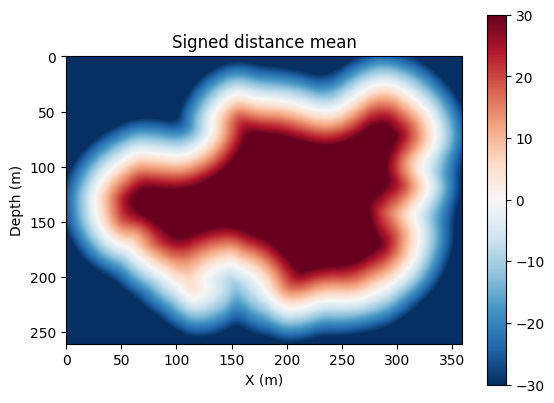

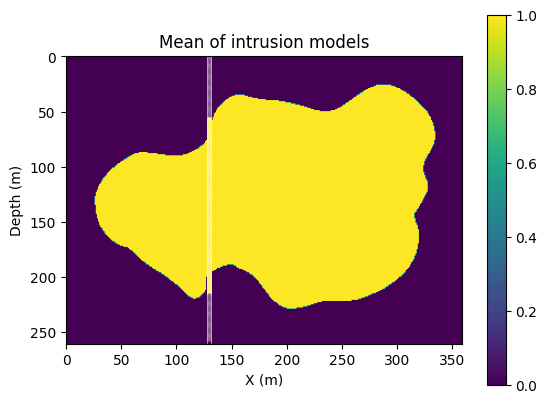

In [20]:
plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0)>0)
plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Mean of intrusion models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

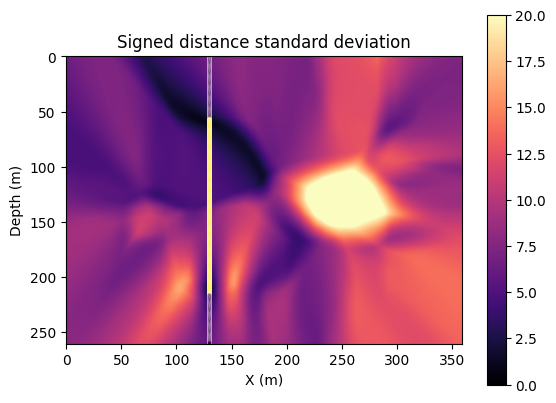

In [21]:
plt.imshow(np.std(model_cache[1000:,:,:],axis = 0),vmin = 0,vmax = 20, cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

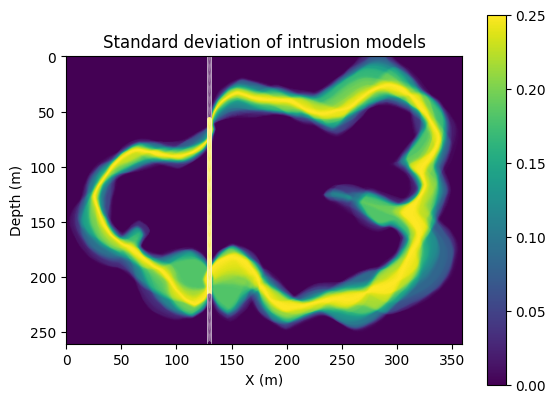

In [22]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

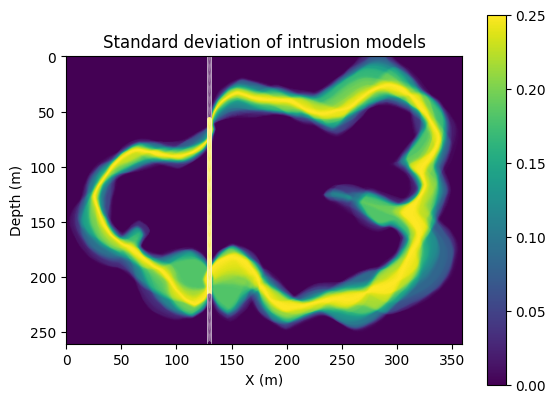

In [23]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)

# plt.scatter(50,50,c = 'C2',s = 40)
# plt.text(50+4,50,'loc1',color = 'w')
# plt.scatter(200,100,c = 'C3',s = 40)
# plt.text(200+4,100,'loc2',color = 'b')

plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

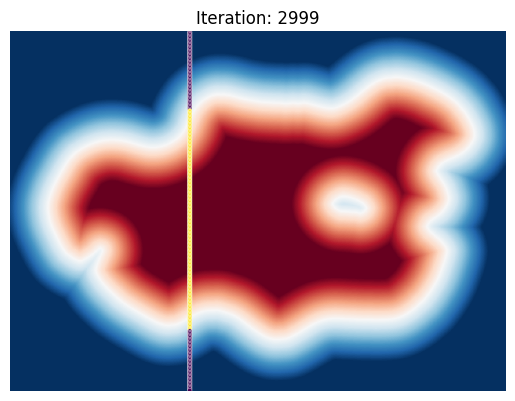

In [24]:
idx = 3000 - 1

plt.imshow(model_cache[idx,:,:],vmin = -30,vmax =30,cmap = 'RdBu_r')
#plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Iteration: '+str(idx))
#plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.axis('off')
plt.show()

In [ ]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

In [97]:
iter_num = 296152200 # 3000
model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(model_cache_mean,label = 'field_mean')
plt.plot(model_cache_std,label = 'field_std')

plt.plot(model_cache[:,50,50],label = 'loc1')
plt.plot(model_cache[:,99,99],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

Text(0.5, 1.0, 'Trace plot')

: 

In [25]:
cut_off = 200
from statsmodels.tsa.stattools import acf
acf_values = np.zeros((7900,model_cache.shape[1],model_cache.shape[2]))
for i in tqdm(range(model_cache.shape[1])):
    for j in range(model_cache.shape[2]):
        acf_values[:,i,j] = acf(model_cache[cut_off:,i,j],nlags = 10000)

100%|██████████| 261/261 [00:51<00:00,  5.07it/s]


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

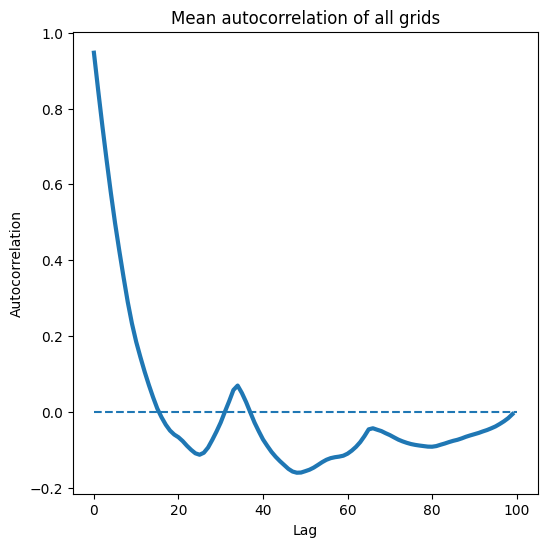

In [26]:
plt.rcParams["figure.figsize"] = (6, 6) 
plt.plot(np.mean(acf_values.reshape(100,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 100,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

In [ ]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.5+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

## residual simulation, velocity extension on each trend

### signed distance for each contact point

In [28]:
idx_at_contact = np.abs(np.gradient(data,axis = 0))>0

In [29]:
mc_pos_sdf = np.copy(model_cache[cut_off:,:,:])
sdf_at_contact = np.zeros((mc_pos_sdf.shape[0],np.sum(idx_at_contact)))
for i in tqdm(range(mc_pos_sdf.shape[0])):
    #mc_pos_sdf[i,:,:] = skfmm.distance(mc_pos[i,:,:]-0.5)
    sdf_at_contact[i,:] = mc_pos_sdf[i,:,:][idx_at_contact]

100%|██████████| 7900/7900 [00:04<00:00, 1912.19it/s]


Text(0.5, 1.0, 'Histogram of signed distance at the contact points')

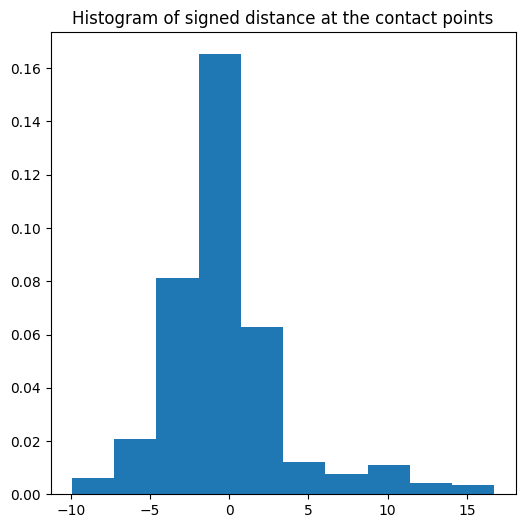

In [30]:
plt.hist(sdf_at_contact.reshape(-1),density = True)
plt.title('Histogram of signed distance at the contact points')

In [32]:
plus_pos = mc_pos_sdf[:,data==1]
minus_pos = mc_pos_sdf[:,data==0]

Text(0.5, 1.0, 'Borehole accuracy')

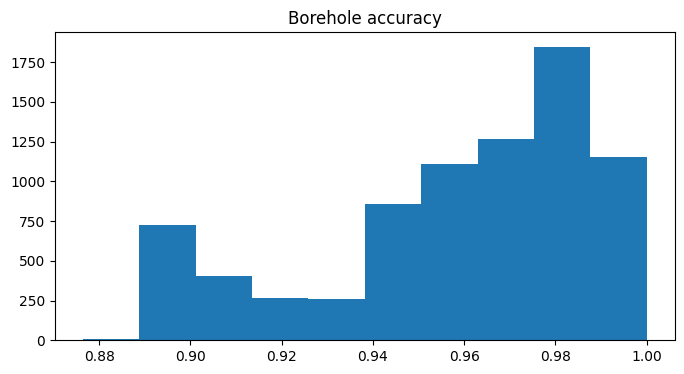

In [33]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0,axis = 1)+np.sum(minus_pos<0,axis = 1))/(np.sum(data==0)+np.sum(data==1)))
plt.title('Borehole accuracy')

## Step 2: M(x) + R(x), Construct velocity with the above variance and do velocity extension

In [34]:
variance = np.var(sdf_at_contact.reshape(-1))

In [35]:
def extension_with_large_velocity(model):
    nx, ny = model.shape
    velocity = generate_m_2D([0,variance,20,20, np.random.uniform(0,180)], np.arange(nx), np.arange(ny), seed = None)
    # Here I choose the range 20 because trend can capture large scale variances larger than 20. 
    [_, F_eval] = skfmm.extension_velocities(model, velocity, dx=[1, 1],order = 1)
    
    max_iter_num = int(np.ceil(np.max(np.abs(F_eval))))
    for ii in range(max_iter_num):
        dt = 1/np.ceil(np.max(np.abs(F_eval)))
        delta_phi = dt * F_eval
        model_next = model - delta_phi # Advection
        model = skfmm.distance(model_next)
    return model

In [36]:
iter_num = 8100
print(model_cache.shape)
mc_pos_sdf_selected = model_cache[np.arange(cut_off,iter_num,100),:,:]

(8100, 261, 360)


In [37]:
mc_pos_sdf_plus_residual = np.zeros(mc_pos_sdf_selected.shape)
for i in tqdm(range(mc_pos_sdf_selected.shape[0])):
    mc_pos_sdf_plus_residual[i,:,:] = extension_with_large_velocity(mc_pos_sdf_selected[i,:,:])

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [01:53<00:00,  1.43s/it]


## Step 3:  M(x) + R(x) with perfect match, Ensemble smoother for final matches

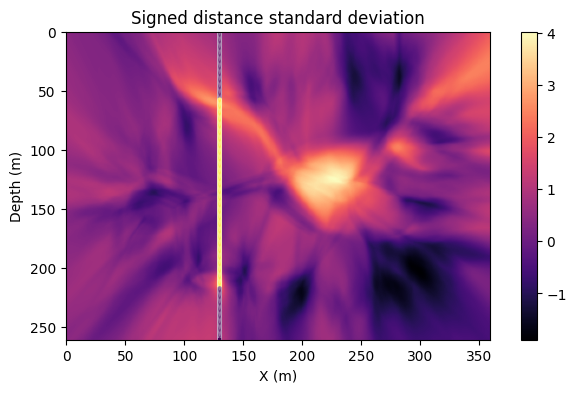

In [38]:
plt.imshow(np.std(mc_pos_sdf_plus_residual[:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0), cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

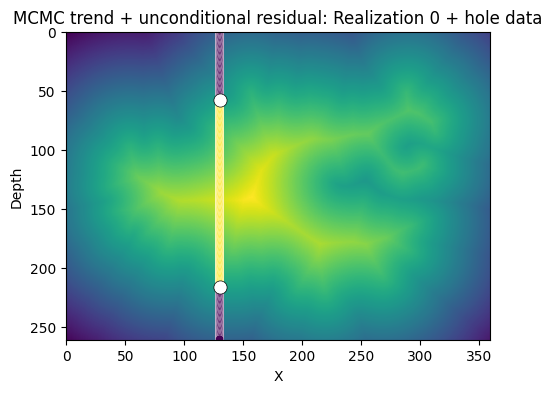

In [39]:
idx = 0
plt.imshow(mc_pos_sdf_plus_residual[idx,:,:])
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3)
plt.scatter(new_contacts['x'][new_contacts['contacts']==1], new_contacts['depth'][new_contacts['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)

plt.title('MCMC trend + unconditional residual: Realization '+str(idx)+' + hole data')
plt.ylabel('Depth'), plt.xlabel('X')
plt.show()

In [40]:
# Sigmoid on DT
def sigmoid(prior_DT):
    return 1/(1 + np.exp(-prior_DT*10))

def ensemble_smoother(m,d,d_obs):
    # no measurement error for now
    # covaraince matrix of d: cov_d
    cov_d = np.cov(d)
    # cross-covariance matrix: cov_m_d, m can be very large so I split into small piece and calculate the covariance matrix.
    start = 0
    sep = 1000
    cov_m_d = np.zeros((m.shape[0],d.shape[0]))
    for end in np.arange(0,m.shape[0],sep)+sep:
        cov_m_d[start:end,:] = np.cov(m[start:end,:],d)[:m[start:end,:].shape[0],m[start:end,:].shape[0]:]
        start = end

    K = np.dot(cov_m_d, np.linalg.inv(cov_d))
    m_pos = m + np.dot(K,d_obs-d)

    return m_pos

In [41]:
mc_pos_sdf_plus_residual_S_DT = sigmoid(mc_pos_sdf_plus_residual)

/var/folders/1c/056txszn77q0jr76_h81g4lm0000gn/T/ipykernel_58239/1161685376.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-prior_DT*10))


In [42]:
data[data == 0.5] = np.nan
d = mc_pos_sdf_plus_residual_S_DT[:,~np.isnan(data)]
d_obs = data[~np.isnan(data)]

d_obs = d_obs[np.var(d,axis = 0)>1e-6] # only invert boreholes with variance > 0.05. Mathemtically > 0 should be fine. 
d = d[:,np.var(d,axis = 0)>1e-6]

In [43]:
mc_pos_sdf_plus_residual_S_DT_pos = ensemble_smoother(mc_pos_sdf_plus_residual_S_DT.reshape(mc_pos_sdf_selected.shape[0],-1).T,
                                                      d.T,d_obs.reshape(-1,1)).T

In [44]:
borehole = new_contacts
def vis_ensembles_mean_var(plot_model):
    
    plt.rcParams['figure.figsize'] = 32, 10
    fig, axs = plt.subplots(1, 5)
    i = 0
    for ax in axs.flat[:3]:
        ax.imshow(plot_model[i*1+1,:,:]>0.5,vmin = 0, vmax = 1)
        ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
        ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
                    c='w', edgecolors='k', linewidths=0.5,s=90)
        ax.axis('off')
        ax.set_title('Realization '+str(i*100+1),fontsize = 25)
        i = i + 1

    ax = axs.flat[3]
    ax.imshow(np.mean(plot_model,axis = 0),vmin = 0, vmax = 1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)
    ax.axis('off')
    ax.set_title('Mean',fontsize = 25)

    ax = axs.flat[4]
    ax.imshow(np.var(plot_model,axis = 0),vmin = 0, vmax = 0.1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)    
    ax.axis('off')
    ax.set_title('Variance',fontsize = 25)

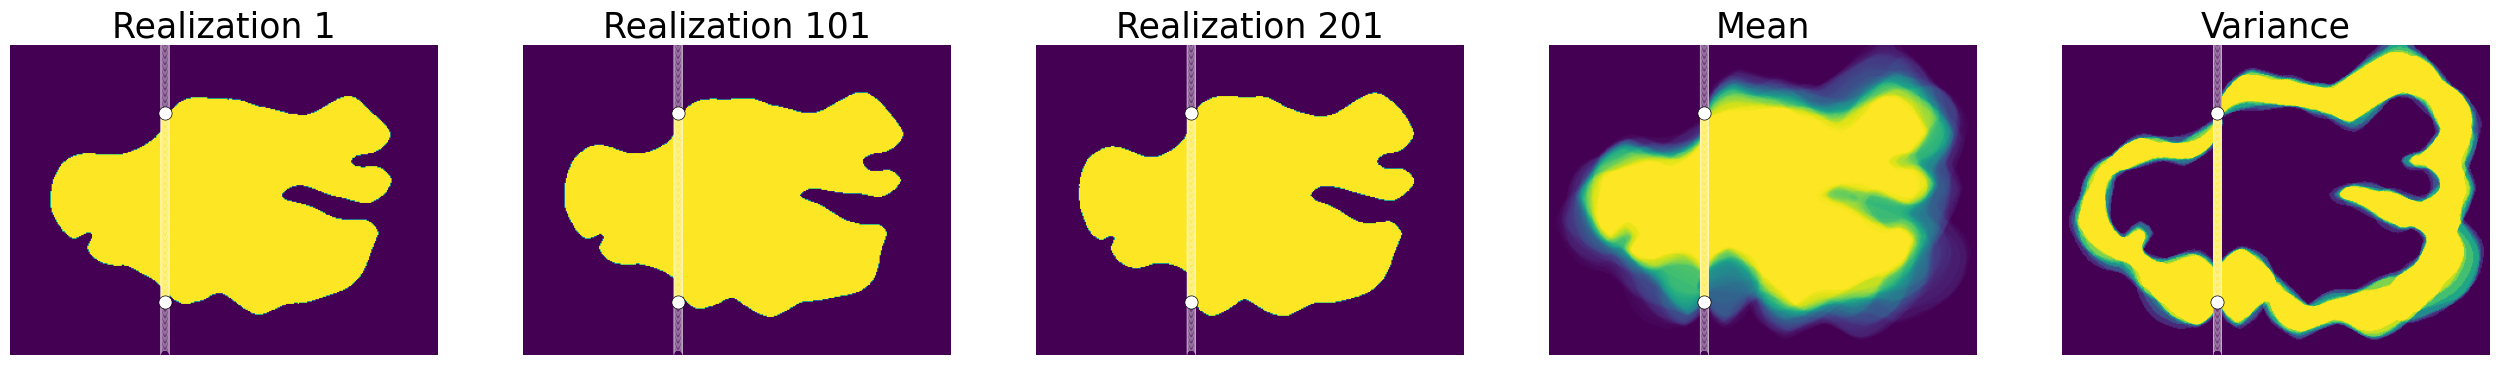

In [45]:
vis_ensembles_mean_var((mc_pos_sdf_selected>0)*1)

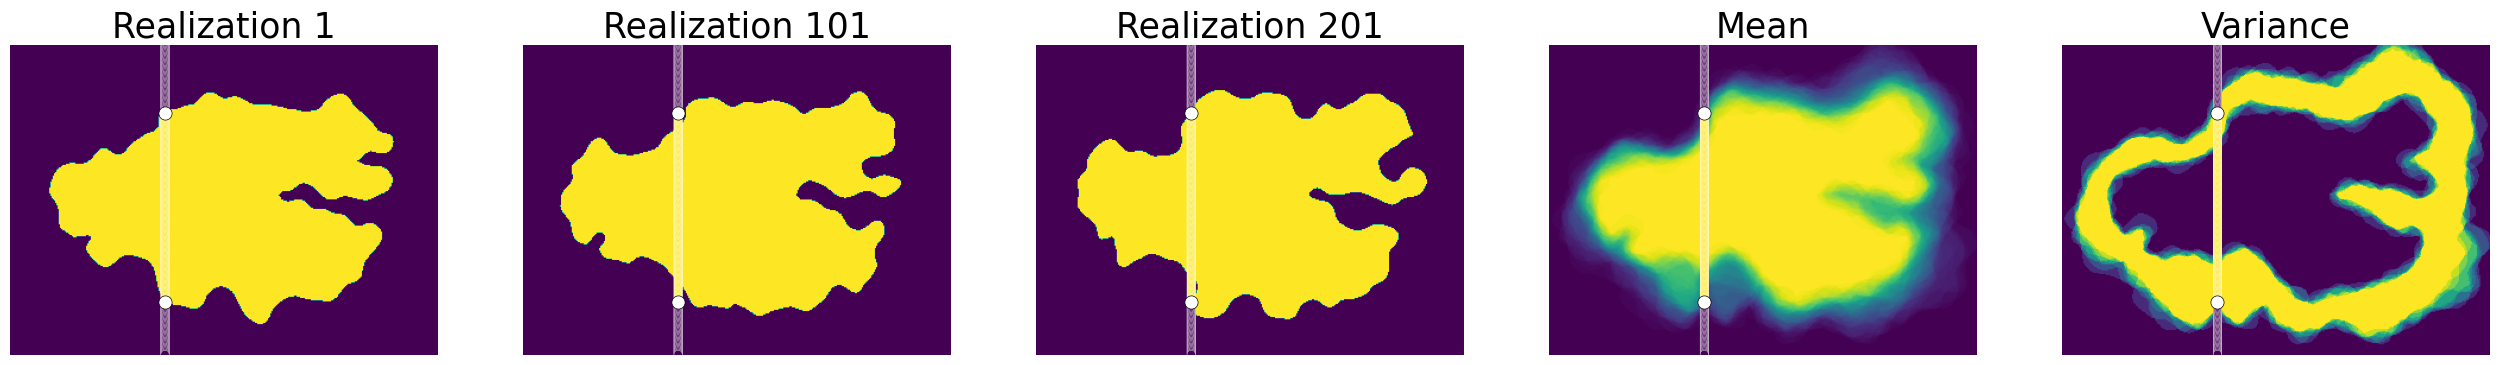

In [46]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT>0.5)*1)

In [56]:
mc_pos_sdf_plus_residual_S_DT_pos = mc_pos_sdf_plus_residual_S_DT_pos.reshape(mc_pos_sdf_selected.shape)

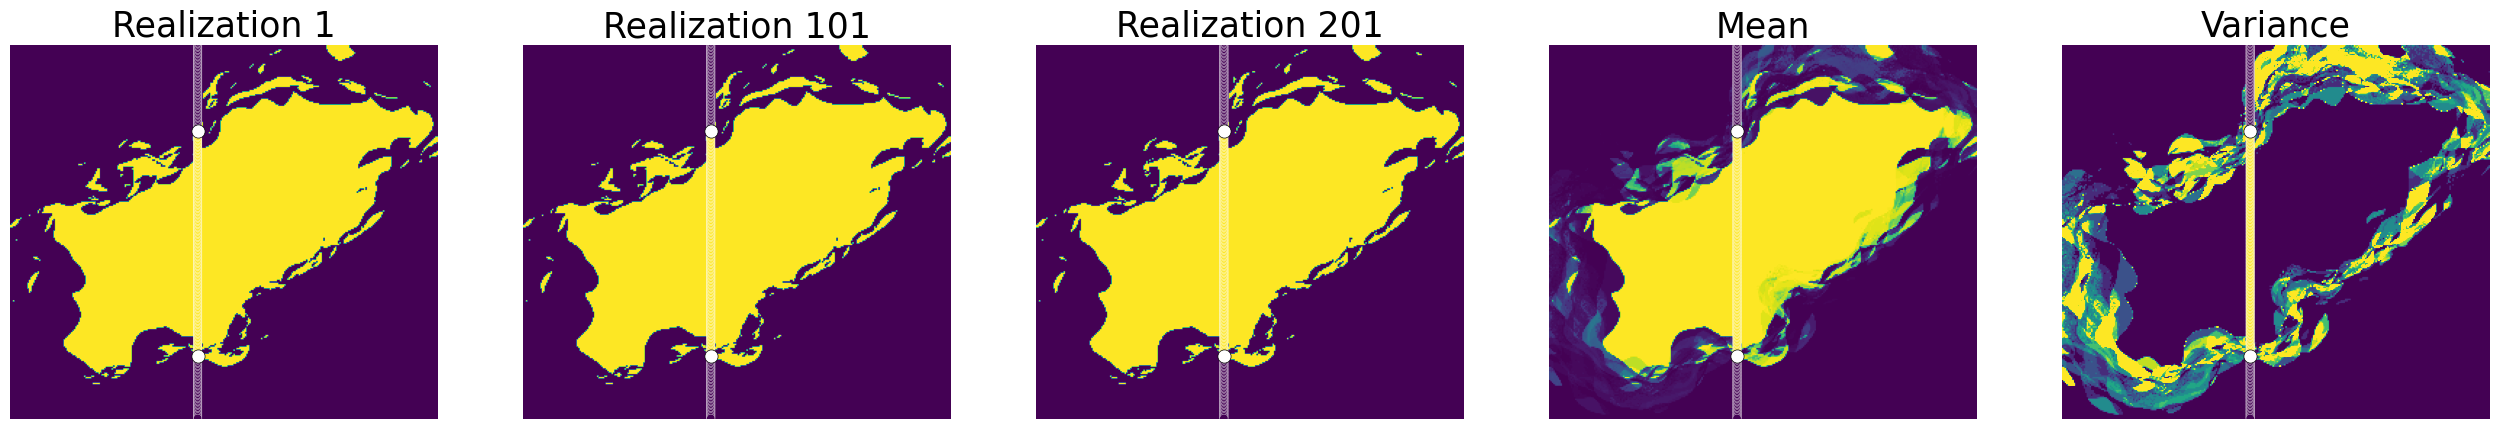

In [57]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT_pos>0.5)*1)

In [73]:
plus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==1]
minus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==0]

(array([ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0., 24.]),
 array([0.93854749, 0.94469274, 0.95083799, 0.95698324, 0.96312849,
        0.96927374, 0.97541899, 0.98156425, 0.9877095 , 0.99385475,
        1.        ]),
 <BarContainer object of 10 artists>)

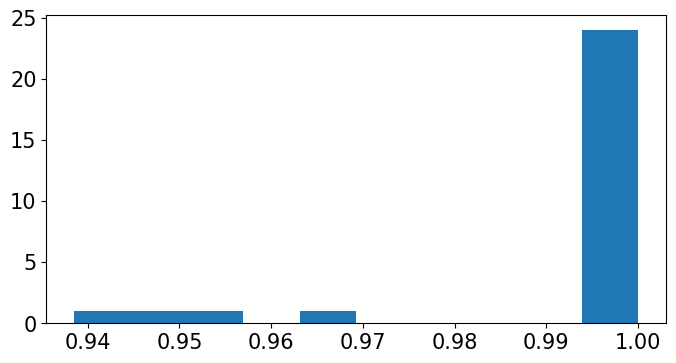

In [74]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0.5,axis = 1)+np.sum(minus_pos<=0.5,axis = 1))/(np.sum(data==0)+np.sum(data==1)))